### 04 — Neural Collaborative Filtering (NCF / MLP)
Train a PyTorch MLP-based recommender using the processed splits:
`data/processed/ratings_train.csv`, `ratings_valid.csv`, `ratings_test.csv`.

**Notes**
- We build user/item id maps from the **union** of all splits to keep indices consistent.
- Model: user & item embeddings → MLP → rating (regression).
- Metrics: RMSE, MAE on validation & test.
- Works on CPU, CUDA, or Apple Silicon (MPS).

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

BASE = Path.cwd().resolve() if Path.cwd().name != 'notebooks' else Path.cwd().parent
if str(BASE) not in sys.path:
    sys.path.append(str(BASE))
if str(BASE / 'src') not in sys.path:
    sys.path.append(str(BASE / 'src'))

from src.ncf_model import (
    build_ncf_model,
    encode_splits,
    RatingsDataset,
    run_epoch,
    build_seen_items,
    recommend_topk,
)

PROC = BASE / 'data' / 'processed'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [2]:
train_df = pd.read_csv(PROC / 'ratings_train.csv')
valid_df = pd.read_csv(PROC / 'ratings_valid.csv')
test_df = pd.read_csv(PROC / 'ratings_test.csv')

for name, df in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
    assert {'userId', 'movieId', 'rating'}.issubset(df.columns), f'{name} missing columns'
    print(name, df.shape, 'n_users:', df.userId.nunique(), 'n_items:', df.movieId.nunique())


train (31316, 7) n_users: 479 n_items: 426
valid (3669, 7) n_users: 479 n_items: 426
test (3669, 7) n_users: 479 n_items: 426


In [3]:
train_enc, valid_enc, test_enc, user2idx, item2idx = encode_splits(train_df, valid_df, test_df)
user2idx_map = user2idx.to_dict()
item2idx_map = item2idx.to_dict()

n_users = len(user2idx)
n_items = len(item2idx)
print('n_users:', n_users, 'n_items:', n_items)


n_users: 479 n_items: 426


In [4]:
# NCF architecture is provided by src.ncf_model.NCF.


In [5]:
# Training helper run_epoch is imported from src.ncf_model.


In [6]:
BATCH = 2048

train_dataset = RatingsDataset(train_enc)
valid_dataset = RatingsDataset(valid_enc)
test_dataset = RatingsDataset(test_enc)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)


In [7]:
EPOCHS = 10
LR = 1e-3
EMB = 64

model = build_ncf_model(n_users, n_items, emb_dim=EMB, device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
best_val = float('inf')
best_ep = None

model_path = BASE / 'models' / 'ncf_best.pth'
model_path.parent.mkdir(parents=True, exist_ok=True)

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_rmse, tr_mae = run_epoch(model, train_loader, criterion, optimizer, device=device)
    val_loss, val_rmse, val_mae = run_epoch(model, valid_loader, criterion, optimizer=None, device=device)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)

    print(f'Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_RMSE={val_rmse:.4f}  val_MAE={val_mae:.4f}')

    if val_rmse < best_val:
        best_val = val_rmse
        best_ep = ep
        torch.save(model.state_dict(), model_path)

print('Best val RMSE:', best_val, 'at epoch', best_ep)


Epoch 01 | train_loss=13.6720  val_loss=12.5532  val_RMSE=3.5452  val_MAE=3.4102
Epoch 02 | train_loss=11.4658  val_loss=7.3837  val_RMSE=2.7194  val_MAE=2.5547
Epoch 03 | train_loss=3.5687  val_loss=1.5061  val_RMSE=1.2246  val_MAE=0.9501
Epoch 04 | train_loss=1.5979  val_loss=0.9279  val_RMSE=0.9656  val_MAE=0.7827
Epoch 05 | train_loss=1.2540  val_loss=0.7495  val_RMSE=0.8671  val_MAE=0.6744
Epoch 06 | train_loss=1.1833  val_loss=0.7289  val_RMSE=0.8551  val_MAE=0.6606
Epoch 07 | train_loss=1.1438  val_loss=0.7277  val_RMSE=0.8545  val_MAE=0.6605
Epoch 08 | train_loss=1.0999  val_loss=0.7275  val_RMSE=0.8541  val_MAE=0.6620
Epoch 09 | train_loss=1.0782  val_loss=0.7306  val_RMSE=0.8561  val_MAE=0.6651
Epoch 10 | train_loss=1.0626  val_loss=0.7283  val_RMSE=0.8545  val_MAE=0.6606
Best val RMSE: 0.8541363477706909 at epoch 8


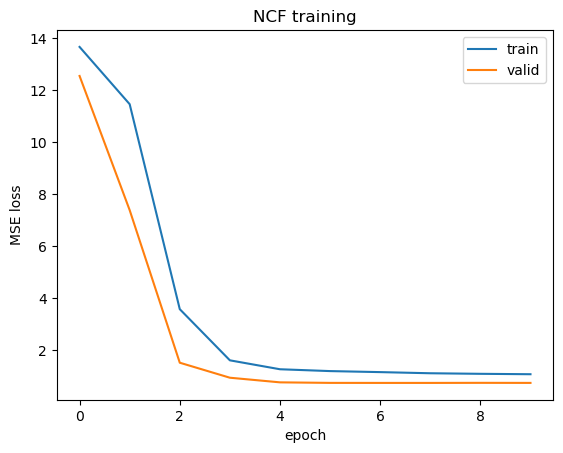

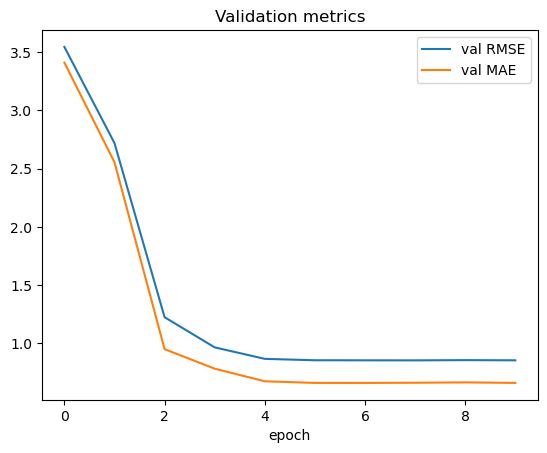

In [8]:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.xlabel('epoch'); plt.ylabel('MSE loss'); plt.legend(); plt.title('NCF training'); plt.show()

plt.figure()
plt.plot(history['val_rmse'], label='val RMSE'); plt.plot(history['val_mae'], label='val MAE')
plt.xlabel('epoch'); plt.legend(); plt.title('Validation metrics'); plt.show()


In [9]:
model.load_state_dict(torch.load(model_path, map_location=device))
test_loss, test_rmse, test_mae = run_epoch(model, test_loader, criterion, optimizer=None, device=device)
print(f'Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}')


Test RMSE: 0.8941 | Test MAE: 0.6923


In [10]:
train_seen = build_seen_items(train_df)

sample_user = int(train_df.userId.sample(1, random_state=42).iloc[0])
topk = recommend_topk(
    model,
    sample_user,
    user2idx=user2idx_map,
    item2idx=item2idx_map,
    train_seen=train_seen,
    k=10,
    device=device,
)
print('Sample user:', sample_user, '-> top10 movieIds:', topk)


Sample user: 591 -> top10 movieIds: [1252, 318, 750, 1199, 912, 1221, 1193, 7361, 904, 1276]
